### 0. Introduction & Setup

Η εργασία αυτή έχει σκοπό να αναλύσουμε
το [Wine data set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) (ερ. 1 έως 12).

Θα κάνουμε ένα data preprocessing, θα βρούμε κάποια
στατιστικά στοιχεία για το dataset, θα δοκιμάσουμε
και θα συγκρίνουμε μια σειρά από prediction τεχνικές.

Ένα επιπλέον ερώτημα (ερ. 13) υπάρχει για association
analysis όπου θα εξαγάγουμε association rules από ένα
dataset από προϊόντα που αγοράστηκαν από ένα κατάστημα.

Τα datasets μπορείτε να τα βρείτε στον ακόλουθο [σύνδεσμο](https://drive.google.com/drive/u/1/folders/1prlqjhk0G06Vd5TzM_nSL-NX-uQxsaKK).
Aνεβάστε τα datasets σε κάποιο δικό σας `path`
στο google drive του δικού σας λογαριασμού.

Αρχικά κάνουμε import τα modules που θα χρειαστούμε.

In [0]:
import typing as t
from enum import Enum
from operator import attrgetter
from pathlib import Path
from warnings import filterwarnings


import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

**Data Mount:** Για να έχετε πρόσβαση στο Google Drive σας
(εκεί όπου θα έχετε ανεβάσει τα δύο parts του dataset)
κάντε mount το drive με την ακόλουθη εντολή.
(Θα σας ζητήσει authentication).

In [0]:
# adapted to also work outside of colab
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except ImportError:
    path = Path('data').resolve()
else:
    path = Path('/content/gdrive/My Drive/DMAssignment/data')

Ένα csv αρχείο που βρίσκεται σε ένα `path` μπορεί να γίνει import
σε ένα numpy array object με τις ακόλουθες γραμμές κώδικα.

In [0]:
ds1 = np.genfromtxt(path / 'dataset_part_one.csv', delimiter=',', skip_header=1)
ds2 = np.genfromtxt(path / 'dataset_part_two.csv', delimiter=',', skip_header=1)

---

### 1. Data Fusion

Κάνουμε import τα δύο parts του dataset
και τα [ενώνουμε](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) σε ένα καινούριο array.

Τα columns (0 - 4) θα έχουν τα δεδομένα από το part 1
και τα columns (5 - 11) τα δεδομένα από το part 2.

In [1]:
class Feat(Enum):
    """An enum that represents dataset features."""
    FA = 0x0, 'Fixed Acidity'
    VA = 0x1, 'Volatile Acidity'
    CA = 0x2, 'Citric Acid'
    RS = 0x3, 'Residual Sugar'
    CH = 0x4, 'Chlorides'
    FS = 0x5, 'Free Sulfur Dioxide'
    TS = 0x6, 'Total Sulfur Dioxide'
    DE = 0x7, 'Density'
    PH = 0x8, 'pH'
    SU = 0x9, 'Sulphates'
    AL = 0xA, 'Alcohol'
    QU = 0xB, 'Quality'

    def __int__(self) -> int:
        return self.value[0]

    def __index__(self) -> int:
        return self.value[0]

    def __str__(self) -> str:
        return self.value[1]


# initial dataset
dataset = np.hstack((ds1, ds2))

### 2. Data Cleaning

Το νέο μας dataset έχει κάποιες NaN τιμές.

[Αφαιρέστε όλα τα records που έχουν κάποιο value NaN](https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-91.php).

In [2]:
# cleaned dataset
clean_ds = dataset[~np.isnan(dataset).any(axis=1)]

### 3. Descriptive Statistics

Ορίστε μια συνάρτηση που δέχεται ως όρισμα το dataset και έναν
ακέραιο. Ο ακέραιος υποδηλώνει ένα feature (column) του dataset.
Η συνάρτηση εμφανίζει στατιστικά measures όπως τα ακόλουθα:

* [Μean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html)
* [Std](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html)
* [Μode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html)
* [Median](https://docs.scipy.org/doc/numpy/reference/generated/numpy.median.html)
* [Max](https://docs.scipy.org/doc/numpy/reference/generated/numpy.amax.html)
* [Min](https://docs.scipy.org/doc/numpy/reference/generated/numpy.amin.html)
* [Skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)
* [Kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)

✔ *Bonus:* Προτείνετε περισσότερες στατιστικές
μετρικές που μπορούν να περιγράψουν ιδιότητες του dataset.

In [3]:
class Metrics(t.NamedTuple):
    """A class that represents various metrics."""
    mean: float = np.NaN
    std: float = np.NaN
    mode: float = np.NaN
    median: float = np.NaN
    max: float = np.NaN
    min: float = np.NaN
    range: float = np.NaN
    skewness: float = np.NaN
    kurtosis: float = np.NaN
    entropy: float = np.NaN

    @classmethod
    def of(cls, dataset: np.ndarray) -> 'Metrics':
        """Calculate the metrics of a dataset."""
        return cls.__new__(cls, **{
            'mean': np.mean(dataset),
            'std': np.std(dataset),
            'mode': st.mode(dataset).mode[0],
            'median': np.median(dataset),
            'max': np.amax(dataset),
            'min': np.amin(dataset),
            'range': np.ptp(dataset),
            'skewness': st.skew(dataset),
            'kurtosis': st.kurtosis(dataset),
            'entropy': st.entropy(dataset, base=2),
        })

    def __str__(self) -> str:
        return '\n'.join(
            f'{k.title()}: {getattr(self, k)}'
            for k in self.__annotations__.keys()
        )

def describe(dataset: np.ndarray, feature: Feat):
    """Print the measurements of a dataset."""
    metrics = Metrics.of(dataset[:, feature])
    print(f'== {feature} ==', metrics, sep='\n')

describe(clean_ds, Feat.FS)
print()  # print a blank line
describe(clean_ds, Feat.TS)

== Free Sulfur Dioxide ==
Mean: 35.30808493262556
Std: 17.005401105808414
Mode: 29.0
Median: 34.0
Max: 289.0
Min: 2.0
Range: 287.0
Skewness: 1.4063140718346216
Kurtosis: 11.453415905047146
Entropy: 12.094805912682013

== Total Sulfur Dioxide ==
Mean: 138.36065741118824
Std: 42.49372602475034
Mode: 111.0
Median: 134.0
Max: 440.0
Min: 9.0
Range: 431.0
Skewness: 0.39059017758152365
Kurtosis: 0.5700448984658744
Entropy: 12.189079539003012


### 4. Histogram Presentation

Ορίστε μια συνάρτηση που δέχεται ως όρισμα το dataset και δύο ακέραιους,
ο πρώτος ακέραιος υποδηλώνει ένα feature (column) του dataset, ο δεύτερος
ακέραιος υποδηλώνει το πλήθος των bins του ιστογράμματος. Η συνάρτηση να
απεικονίζει το ιστόγραμμα του feature που επιλέχθηκε συναρτήσει των αντίστοιχων bins.

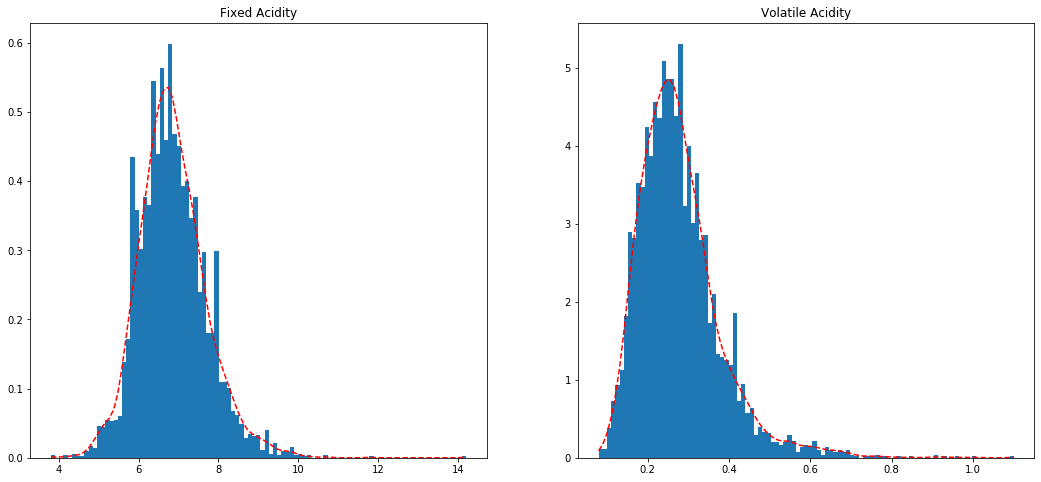

In [4]:
%matplotlib inline

from scipy.stats import gaussian_kde


def histogram(dataset: np.ndarray, feature: Feat, bins: int):
    """Create a histogram + density plot"""
    array = dataset[:, feature]
    pts = plt.hist(array, bins - 1, density=True)[1]
    plt.plot(pts, gaussian_kde(array)(pts), '--', c='r')
    plt.title(feature)


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
histogram(clean_ds, Feat.FA, 100)

plt.subplot(1, 2, 2)
histogram(clean_ds, Feat.VA, 100)

plt.show()

### 5. [Probability Outlier Detection](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

Ορίστε μια συνάρτηση που δέχεται ως όρισμα το dataset και έναν ακέραιο.
Ο ακέραιος υποδηλώνει ένα feature (column) του dataset και εντοπίζει τα
outliers χρησιμοποιώντας την μέθοδο του Interquartile Range **(IQR)**.

1. Το IQR υπολογίζεται ως το εύρος των τιμών ενός feature
   που είναι μεγαλύτερο από το 25% [percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) **(Q1)** και
   μικρότερο από το 75% [percentile](https://en.wikipedia.org/wiki/Percentile) **(Q3)** του. Οπότε `IQR = Q3 - Q1`.
2. Outlier θεωρείται μια τιμή όταν είναι μικρότερη από το
   `Q1 - 1.5 * IQR` ή μεγαλύτερη από το `Q3 + 1.5 * IQR`.

✔ *Bonus:* Υλοποιήστε και εφαρμόστε περισσότερες outlier
detection τεχνικές που υπάρχουν διαθέσιμες στην βιβλιογραφία.

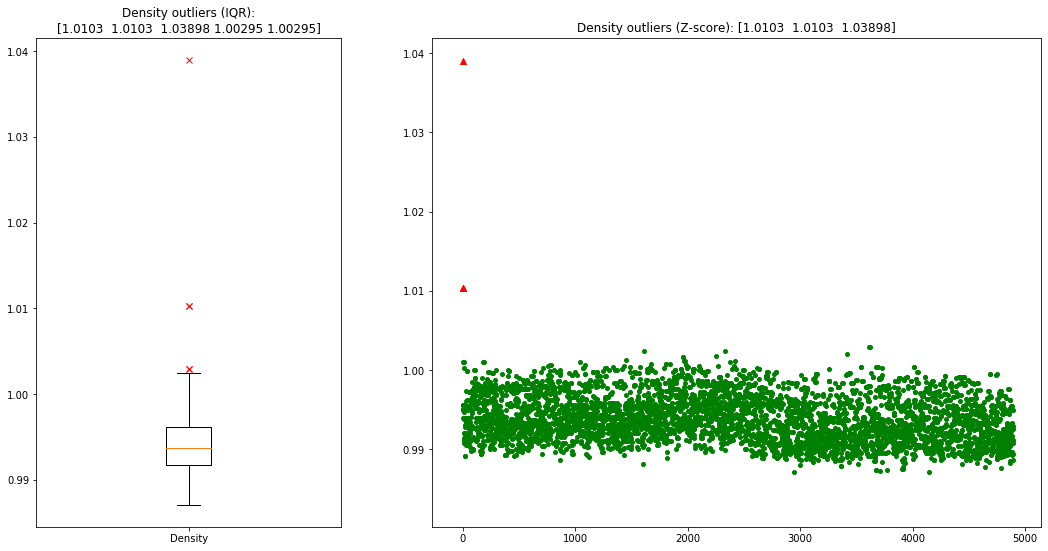

In [5]:
def iqr_outliers(dataset: np.ndarray, feature: Feat,
                 thresh: float = 1.5) -> np.ndarray:
    """Find the outliers using an IQR threshold."""
    array = dataset[:, feature]
    q1, q3 = np.percentile(array, (25, 75))
    iqr = np.subtract(q3, q1)
    out1 = q1 - thresh * iqr
    out3 = q3 + thresh * iqr
    return array[(array < out1) | (array > out3)]


def zscore_outliers(dataset: np.ndarray, feature: Feat,
                    thresh: float = 3.0) -> np.ndarray:
    """Find the outliers using a Z-score threshold."""
    array = dataset[:, feature]
    zscore = (array - array.mean()) / array.std()
    return array[np.abs(zscore) > thresh]



fig, (p1, p2) = plt.subplots(
    1, 2, figsize=(18, 9), gridspec_kw={'width_ratios': (1, 2)}
)

# create a boxplot of the density data
de_data = clean_ds[:, Feat.DE]
de_outl = iqr_outliers(clean_ds, Feat.DE)
p1.boxplot(de_data, labels=(Feat.DE,), sym='rx')
p1.set_title(f'{Feat.DE} outliers (IQR):\n{de_outl}')

# create a scatter plot of the density data
de_outl = zscore_outliers(clean_ds, Feat.DE)
de_data = de_data[~np.isin(de_data, de_outl)]
p2.scatter(np.arange(de_data.shape[0]), de_data, 16, 'g', 'o')
p2.scatter(np.arange(de_outl.shape[0]), de_outl, 36, 'r', '^')
p2.set_title(f'{Feat.DE} outliers (Z-score): {de_outl}')

plt.show()

### 6. Binary-label Dataset

Η τελευταία στήλη του dataset είναι η ποιότητα του κρασιού
βαθμονομημένη από το 0 έως το 10. Θεωρούμε ως κακή ποιότητα
τους βαθμούς 0 εως και 5 και ως καλή μια ποιότητα από 6 εως 10.

Αντικαταστήστε την τελευταία στήλη του dataset με την
τιμή 0 αν το εξεταζόμενο κρασί είναι κακής ποιότητας
και 1 αν το εξεταζόμενο κρασί είναι καλής ποιότητας.

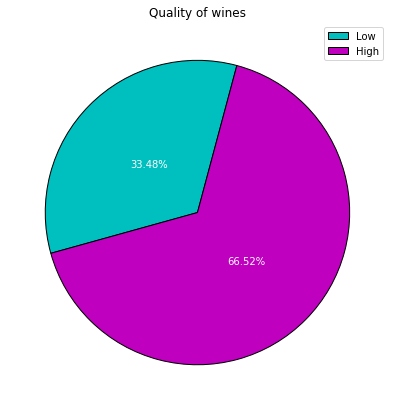

In [6]:
# binarise the quality feature
clean_ds[:, Feat.QU] = clean_ds[:, Feat.QU] > 5
# count each value
counts = np.bincount(clean_ds[:, Feat.QU] == 1)

# create a pie plot of the counts
plt.figure(figsize=(9, 7))
plt.pie(
    counts, colors=('c', 'm'), pctdistance=0.45,
    autopct='%1.2f%%', textprops={'color': 'w'},
    startangle=75, wedgeprops={'edgecolor': 'k'}
)
plt.title(f'{Feat.QU} of wines')
plt.legend(('Low', 'High'))
plt.show()

### 7. Data Rescaling

Χρησιμοποιήστε την τεχνική
[Data Normalization ή Data Standardization](https://scikit-learn.org/stable/modules/preprocessing.html)
για να γίνει κανονικοποίηση των δεδομένων.

*(Σημείωση: Η κανονικοποίηση να γινει για κάθε
feature ξεχωριστά και δεν κανονικοποιούμε τo quality.)*

In [7]:
from sklearn.preprocessing import RobustScaler

# separate the quality feature
qualities = clean_ds[:, Feat.QU]
clean_ds = np.delete(clean_ds, int(Feat.QU), axis=1)
# normalise dataset with RobustScaler to reduce outliers
norm_ds = RobustScaler().fit_transform(clean_ds)

### 8. Binary Classification

[Χωρίζουμε το Dataset μας σε 67% training και 33% testing](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
Εκπαιδεύουμε στο training part τους classifiers:

* [DT](https://scikit-learn.org/stable/modules/tree.html)
* [SVM](https://scikit-learn.org/stable/modules/svm.html)
* [Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [ANN](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

Κάνουμε evaluation στο testing part και παρουσιάζουμε
σε ένα πινακάκι για κάθε classifier τις μετρικές
[precision, recall, f-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

Ποιος classifier έχει τα καλύτερα αποτελέσματα;

Να δοκιμάσετε με διάφορες υπερπαραμέτρους για κάθε classifier
και να προτείνετε το καλύτερο configuration υπερπαραμέτρων.

Μπορείτε να εφαρμόσετε κάποια τεχνική για να μειώσετε το overfitting;

✘ *Bonus:* Εφαρμόστε περισσότερες Classification
μεθόδους που υπάρχουν στην βιβλιογραφία.

✘ *Bonus:* Αν εκπαιδεύσουμε τον classifier σε ένα
training dataset που έχουν αφαιρεθεί οι outliers
θα έχουμε καλύτερες προβλέψεις στο testing dataset.

✘ *Bonus:* Τα outlier records έχουν μεγαλύτερη πιθανότητα να μην
κατηγοριοποιηθούν σωστά σε σχέση με τα φυσιολογικά records;

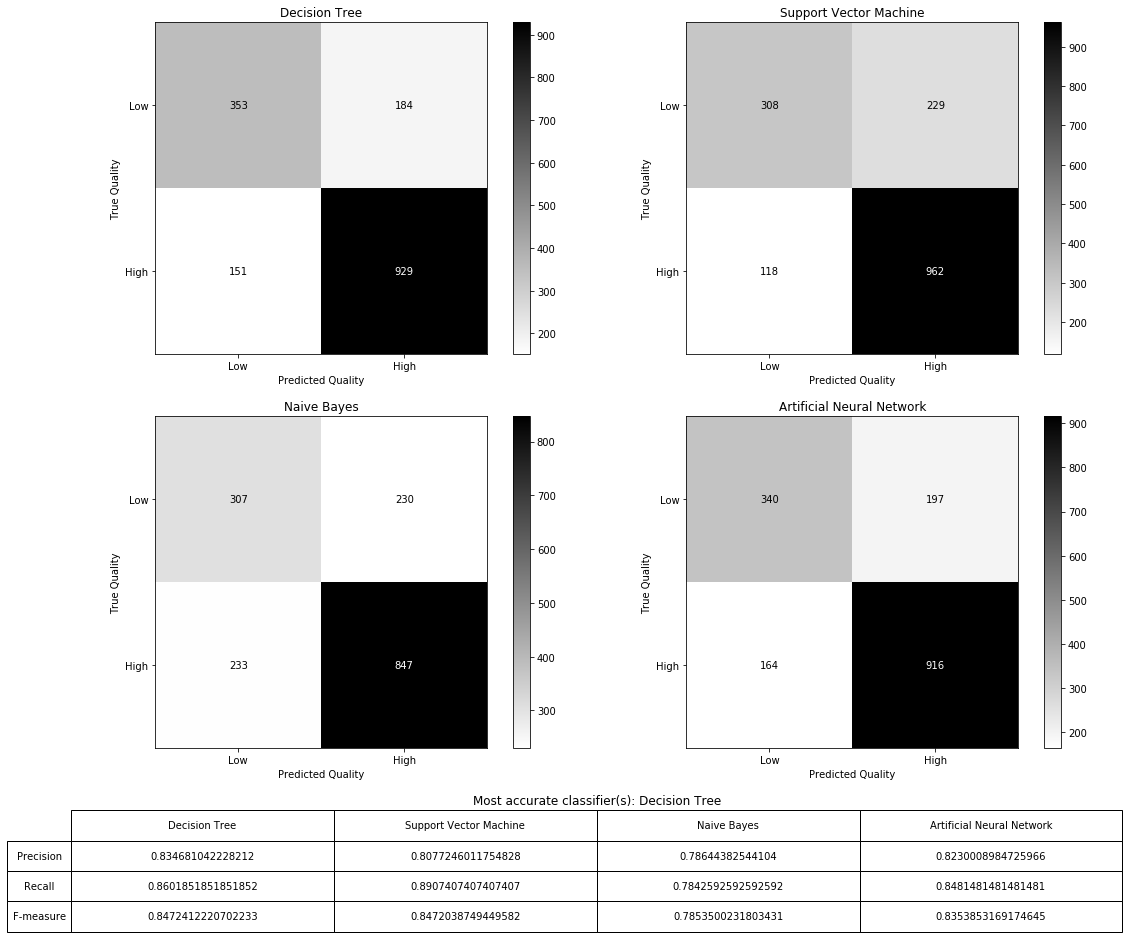

In [8]:
from sklearn.base import ClassifierMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    accuracy_score, plot_confusion_matrix, precision_recall_fscore_support
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

filterwarnings('ignore', category=ConvergenceWarning)


class CLFWrapper:
    """Wrapper class for any classifier."""
    def __init__(self, base: ClassifierMixin, name: str, *args, **kwargs):
        self._X, self._y = args[2:]
        # search for optimal hyper parameters
        self._clf = GridSearchCV(base, kwargs, 'f1', n_jobs=4).fit(*args[:2])
        self.params = self._clf.best_params_
        self.accuracy = self._clf.score(self._X, self._y)
        self.scores = precision_recall_fscore_support(
            self._y, self._clf.predict(self._X), average='binary'
        )[:-1]
        self.name = name

    def __str__(self) -> str:
        return self.name

    def __repr__(self) -> str:
        return f'CLFWrapper({self.name})'

    def plot(self, axes: t.Optional[plt.Axes] = None):
        """Plot the confusion matrix of the classifier."""
        plot_confusion_matrix(
            self._clf, self._X, self._y, values_format='d',
            display_labels=('Low', 'High'), ax=axes, cmap='binary'
        ).ax_.set(
            xlabel=f'Predicted {Feat.QU}',
            ylabel=f'True {Feat.QU}',
            title=self.name
        )


grid = plt.figure(figsize=(15, 13)).add_gridspec(
    nrows=3, ncols=2, height_ratios=(3, 3, 1)
)
train_X, test_X, train_y, test_y = train_test_split(
    norm_ds, qualities, train_size=0.67, test_size=0.33
)

# initialise and plot the DT classifier
dt_clf = CLFWrapper(
    DecisionTreeClassifier(random_state=0), 'Decision Tree',
    train_X, train_y, test_X, test_y,
    criterion=('gini', 'entropy'),
    max_features=np.arange(2, len(Feat))
)
dt_clf.plot(grid.figure.add_subplot(grid[0, 0]))

# initialise and plot the SVM classifier
svm_clf = CLFWrapper(
    SVC(random_state=0), 'Support Vector Machine',
    train_X, train_y, test_X, test_y,
    tol=10.0 ** np.arange(-5, 0),
    C=np.logspace(-1, 0, 10)
)
svm_clf.plot(grid.figure.add_subplot(grid[0, 1]))

# initialise and plot the Bayes classifier
bayes_clf = CLFWrapper(
    GaussianNB(), 'Naive Bayes',
    train_X, train_y, test_X, test_y,
    var_smoothing=np.linspace(1e-7, 1e-2, 10)
)
bayes_clf.plot(grid.figure.add_subplot(grid[1, 0]))

# initialise and plot the ANN classifier
ann_clf = CLFWrapper(
    MLPClassifier(random_state=0), 'Artificial Neural Network',
    train_X, train_y, test_X, test_y,
    activation=('tanh', 'relu'),
    epsilon=np.random.uniform(1e-9, 1e-7, 5)
)
ann_clf.plot(grid.figure.add_subplot(grid[1, 1]))

# create an array of all the classifiers
clfs = np.array([dt_clf, svm_clf, bayes_clf, ann_clf])
# and an array of their accuracies
accs = np.vectorize(attrgetter('accuracy'), 'd')(clfs)
# there could be more than one equally accurate
best = clfs[np.argwhere(accs == accs.max()).flatten()].astype(str)

# show the classifiers' metrics in a table
tbl = grid.figure.add_subplot(grid[2, :])
tbl.table(
    loc='center', bbox=(0.0, -0.1, 1.0, 1.1),
    rowLabels=('Precision', 'Recall', 'F-measure'),
    colLabels=clfs, cellLoc='center', rowLoc='center',
    cellText=np.vectorize(attrgetter('scores'), 'ddd')(clfs)
)
tbl.set_title(f'Most accurate classifier(s): {", ".join(best)}')
tbl.axis('off')

plt.tight_layout(h_pad=1.5)
plt.show()

### 9. Majority Class Classifier

Πόσο βελτιώθηκε η ακρίβεια πρόβλεψης με κάποιον από τους
προηγούμενους classifiers σε σχέση με έναν Dummy classifier
που προβλέπει πάντα το πιο συχνό label του training dataset;

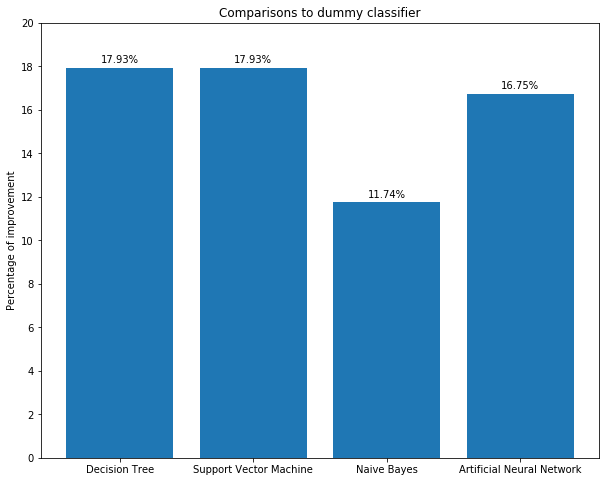

In [9]:
from matplotlib.container import BarContainer
from sklearn.dummy import DummyClassifier


def annotate(bar: BarContainer):
    """Annotate a bar plot with the values."""
    for rect in bar:
        h, w, x = rect.get_height(), rect.get_width(), rect.get_x()
        plt.annotate(
            f'{h:1.2f}%', xy=(x + w / 2, h), xytext=(0, 3),
            textcoords='offset points', ha='center', va='bottom'
        )


# initialise the majority class classifier
dummy = DummyClassifier(strategy='most_frequent').fit(train_X, train_y)
# compute the differences in accuracy
diffs = (accs - dummy.score(test_X, test_y)) * 100

plt.figure(figsize=(10, 8))
# plot the differences in accuracy
annotate(plt.bar(np.arange(len(diffs)), diffs, tick_label=clfs))
# stretch y axis upwards to a multiple of 10
mul10 = np.ceil(np.log10(diffs.max()))
plt.yticks(np.arange(mul10 * 10 + 1, step=mul10))
plt.ylabel('Percentage of improvement')
plt.title('Comparisons to dummy classifier')
plt.show()

### 10. Regression

Tο feature sulphates στο μέλλον δεν θα μπορεί να προσφέρεται
μέσω χημικής ανάλυσης, αλλά έχουμε αρκετά records για να το
προβλέπουμε εμείς. Δοκιμάστε να γίνεται η πρόβλεψη του μέσω
[regression](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) τεχνικών. Aξιολογηστε το κάθε regression μοντέλο
με τις μετρικές [Mean absolute error και Mean squared error](https://scikit-learn.org/stable/modules/model_evaluation.html).

Δοκιμάστε να κάνετε Normalize και standardize τα features.

Το normalization και το standardization μειώνει το error των προβλέψεων;

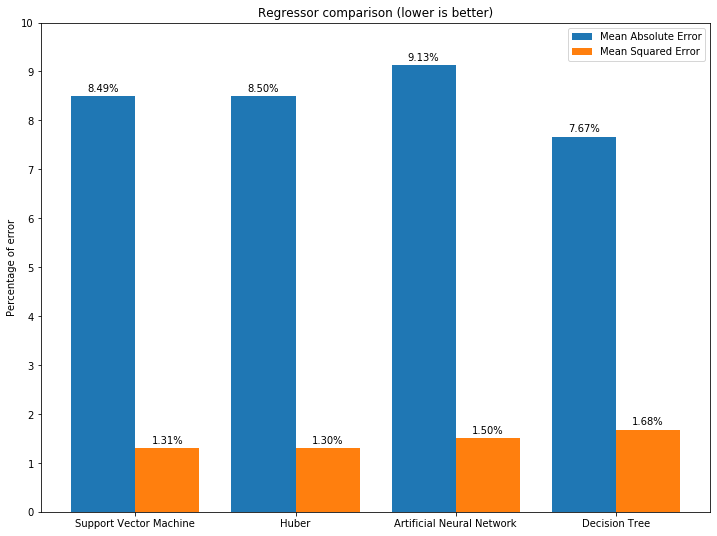

In [10]:
from sklearn.linear_model import HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = np.vectorize(mean_absolute_error, 'd', signature='(m),(n)->()')
mse = np.vectorize(mean_squared_error, 'd', signature='(m),(n)->()')

# remove sulphates from the dataset
sulphates = clean_ds[:, Feat.SU]
regr_ds = np.delete(clean_ds, int(Feat.SU), axis=1)
train_Xr, test_Xr, train_yr, test_yr = train_test_split(regr_ds, sulphates)

# initialise SVM, Huber, ANN, DT regressors
svm_reg = SVR(epsilon=0.01).fit(train_Xr, train_yr)
lin_reg = HuberRegressor(epsilon=1.0, max_iter=600).fit(train_Xr, train_yr)
ann_reg = MLPRegressor(random_state=0, tol=1e-9).fit(train_Xr, train_yr)
dt_reg = DecisionTreeRegressor(random_state=0).fit(train_Xr, train_yr)

# get the predictions of each regressor
regs = [svm_reg, lin_reg, ann_reg, dt_reg]
preds = [r.predict(test_Xr) for r in regs]
# calculate the MAE & MSE of the predictions
ma_errs = mae([test_yr], preds) * 100
ms_errs = mse([test_yr], preds) * 100

plt.figure(figsize=(12, 9))
nums = np.arange(len(regs))
# plot the MAE & MSE of each regressor
annotate(plt.bar(nums - 0.2, ma_errs, 0.4, label='Mean Absolute Error'))
annotate(plt.bar(nums + 0.2, ms_errs, 0.4, label='Mean Squared Error'))
# stretch y axis upwards to a multiple of 10
mul10 = np.ceil(np.log10(np.max([ma_errs, ms_errs])))
plt.yticks(np.arange(mul10 * 10 + 1, step=mul10))
plt.ylabel('Percentage of error')
plt.xticks(nums, (
    'Support Vector Machine', 'Huber',
    'Artificial Neural Network', 'Decision Tree'
))
plt.title('Regressor comparison (lower is better)')
plt.legend()
plt.show()

### 11. Clustering (a)

Έστω ότι θέλουμε να αποθηκεύσουμε τα κρασιά σε έναν αριθμό από Κ-αποθήκες.
Το  κριτήριο που θα επιλέξουμε ποια θα αποθηκευτούν μαζί είναι οι φυσικοχημικές
μετρίσεις τους να έχουν τον μεγιστο βαθμό ομοιότητας. Χρησιμοποιήστε την μέθοδο
[k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) για να βρείτε ποια records (ετικέτες κρασιών) θα συσταδοποιηθουν μαζί.

Με την [μέθοδο του αγκώνα (elbow method)](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) βρείτε το βέλτιστο πλήθος συστάδων Κ.

Για το Κ που επιλέξατε αξιολογηστε την συσταδοποίηση
που παράγεται με την μετρική [silhouette](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient).

Δοκιμάστε (trial and error) διάφορες υπερπαραμέτρους.

✔ *Bonus:* [Hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Η trial and error εύρεση
των υπερπαραμέτρων μπορεί να είναι μια κοπιαστική διαδικασία και
πολύ πιθανόν να μην δοκιμαστουν συνδυασμοί που έχουν πολύ καλά
αποτελέσματα. Εφαρμόστε είτε στο Classification ερώτημα (8) είτε
στα Clustering (11 & 12) κάποια Hyperparameter optimization τεχνική.

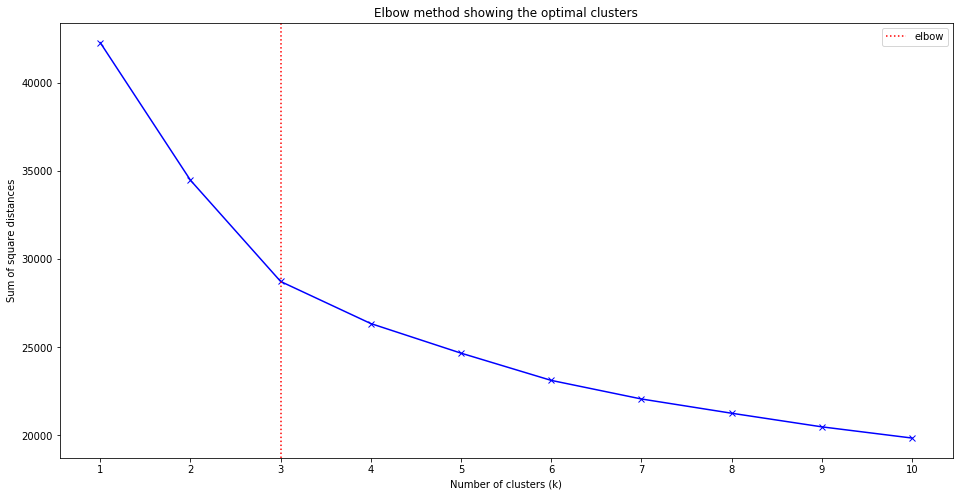

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = range(1, 11)
# initialise multiple K-Means and calculate their inertias
kms = [KMeans(n_clusters=k).fit(norm_ds) for k in K]
inrt = [k.inertia_ for k in kms]

# elbow point = max point of the 2nd derivative
bkm = kms[np.argmax(np.gradient(np.gradient(inrt)))]
# get the silhouette score of the best K-Means
silk = silhouette_score(norm_ds, bkm.labels_)

plt.figure(figsize=(16, 8))
# plot the elbow method
plt.plot(K, inrt, 'bx-')
plt.axvline(bkm.n_clusters, c='r', linestyle=':', label='elbow')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of square distances')
plt.xticks(K)  # show all clusters
plt.title('Elbow method showing the optimal clusters')
plt.legend()
plt.show()

# separate the clusters
km_clusters = [clean_ds[bkm.labels_ == k, :] for k in range(bkm.n_clusters)]

### 12. Clustering (b)

Εφαρμόστε την μέθοδο [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), δοκιμάστε για διάφορα eps,
βρείτε το διαφορετικό πλήθος απο clusters που σχηματίζονται
και αξιολογήστε τα αποτελέσματα με την Silhouette μετρική.

Δοκιμάστε (trial and error) διάφορες υπερπαραμέτεους.
Η k-means ή DBSCAN παράγει καλύτερες συσταδοποιήσεις;

✔ *Bonus:* Δοκιμάστε περισσότερες από τις διαθέσιμες
τεχνικές [clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) και συγκρίνετε τα αποτελέσματα.

✔ *Bonus:* Αξιολογήστε κάθε συσταδοποίηση με περισσότερες απο τις διαθέσιμες
[μετρικές αξιολόγησης συσταδοποιήσεων](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) και να αναφέρετε τι εκφράζουν.

✘ *Bonus:* H έκφραση "clusters are in the eye of the beholder"
χρησιμοποιείται συχνά στα προβλήματα συσταδοποίησης.
Γράψτε μια μικρή αναφορά για την κάθε μέθοδο συσταδοποίησης
σε ποιες ιδιότητες των features βασίζεται και κάθε μετρική
αξιολόγησης ποιες ιδιότητες των συστάδων εκφράζει.

In [12]:
from sklearn.cluster import Birch, DBSCAN
from sklearn.metrics import (
    calinski_harabasz_score, davies_bouldin_score
)

# initialise Birch & DBSCAN
bch = Birch(n_clusters=bkm.n_clusters).fit(norm_ds)
dbs = DBSCAN(eps=2.0).fit(norm_ds)

# print each model's silhouette score (compares distances)
silb = silhouette_score(norm_ds, bch.labels_)
sild = silhouette_score(norm_ds, dbs.labels_)
print(f'K-Means Silhouette Coefficient: {silk}')
print(f'Birch   Silhouette Coefficient: {silb}')
print(f'DBSCAN  Silhouette Coefficient: {sild}\n')

# print each model's Davies-Bouldin score (compares distances & sizes)
dabk = davies_bouldin_score(norm_ds, bkm.labels_)
dabb = davies_bouldin_score(norm_ds, bch.labels_)
dabd = davies_bouldin_score(norm_ds, dbs.labels_)
print(f'K-Means Davies-Bouldin Index: {dabk}')
print(f'Birch   Davies-Bouldin Index: {dabb}')
print(f'DBSCAN  Davies-Bouldin Index: {dabd}\n')

# print each model's Calinski-Harabasz score (compares dispersions)
cahk = calinski_harabasz_score(norm_ds, bkm.labels_)
cahb = calinski_harabasz_score(norm_ds, dbs.labels_)
cahd = calinski_harabasz_score(norm_ds, dbs.labels_)
print(f'K-Means Calinski-Harabasz Index: {cahk}')
print(f'Birch   Calinski-Harabasz Index: {cahb}')
print(f'DBSCAN  Calinski-Harabasz Index: {cahd}')

K-Means Silhouette Coefficient: 0.18261067370555267
Birch   Silhouette Coefficient: 0.1533128770750248
DBSCAN  Silhouette Coefficient: 0.29806756834904474

K-Means Davies-Bouldin Index: 1.5812049883061807
Birch   Davies-Bouldin Index: 1.7004221320767812
DBSCAN  Davies-Bouldin Index: 1.7874472592123714

K-Means Calinski-Harabasz Index: 1154.537408763425
Birch   Calinski-Harabasz Index: 201.8141497128703
DBSCAN  Calinski-Harabasz Index: 201.8141497128703


### 13. Association Rules

Για το ερώτημα των association rules θα χρησιμοποιήσουμε
ένα dataset με προϊόντα που αγοράστηκαν από ένα super
market και θα χρησιμοποιήσουμε το module apyori.

Εγκαθιστούμε το module [apyori](https://zaxrosenberg.com/unofficial-apyori-documentation/) και κάνουμε
import τα transactions με τις ακόλουθες εντολές.

Βρείτε για διάφορες τιμές του confidence, του support και του
lift τα association rules που παράγονται με τον αλγόριθμο apriori.

In [13]:
!pip install apyori > /dev/null

import pandas as pd
from apyori import apriori


def _item_filter(item: t.List[str]) -> bool:
    """Filter out items with blank entries."""
    return len(item) > 0 and item[0] != ''


# read the transactions and replace nan with a blank string
transactions = pd.read_csv(path / 'transactions.csv').fillna(value='')
# get the association rules of the transactions
associations = apriori(
    transactions.values.tolist(),
    min_confidence=0.2, min_lift=3,
    min_length=2, min_support=5e-3
)

# print the characteristics of each rule
for rule in associations:
    items = filter(_item_filter, list(rule.items))
    stats = rule.ordered_statistics[0]
    print('-' * 48)
    print('Rule:', ', '.join(items))
    print('Lift:' stats.lift)
    print('Support:', rule.support)
    print('Confidence:', stats.confidence)

------------------------------------------------
Rule: escalope, mushroom cream sauce
Lift: 3.7903273197390845
Support: 0.005733333333333333
Confidence: 0.30069930069930073
------------------------------------------------
Rule: pasta, escalope
Lift: 4.700185158809287
Support: 0.005866666666666667
Confidence: 0.37288135593220345
------------------------------------------------
Rule: ground beef, herb & pepper
Lift: 3.2915549671393096
Support: 0.016
Confidence: 0.3234501347708895
------------------------------------------------
Rule: tomato sauce, ground beef
Lift: 3.840147461662528
Support: 0.005333333333333333
Confidence: 0.37735849056603776
------------------------------------------------
Rule: olive oil, whole wheat pasta
Lift: 4.130221288078346
Support: 0.008
Confidence: 0.2714932126696833
------------------------------------------------
Rule: pasta, shrimp
Lift: 4.514493901473151
Support: 0.005066666666666666
Confidence: 0.3220338983050848
------------------------------------------